Import necessary packages

In [1]:
from functions import *

%matplotlib inline

Set appropriate parameters

In [2]:
activityfile = '../Data (Algebra 1)/YearUsageActivity.csv'
bgmm = BayesianGaussianMixture(n_components=5, max_iter=1000)
birch = Birch(n_clusters=5)
kmeans = KMeans(n_clusters=5)

# Import Data

Load user data into a dataframe. Stephen compiled this data.

In [3]:
userdf = readData(activityfile)

In [4]:
columnLabels = getColumnLabels(userdf)

See Data Exploration to show why we are replacing session time and number of sessions with the 99th percentile value

In [5]:
userdf = replaceDataFrameOutliers(userdf,['sessionTime','NumSessions'])

In [6]:
summaryStats(userdf)

235756 samples


,desktop,spring,hour,sessionTime,NumSessions
mean,0.85,0.62,14.44,22.47,9.08
std,0.28,0.41,4.41,21.94,13.02
min,0.00,0.00,0.00,0.50,1.00
25%,0.83,0.21,12.75,1.00,1.00
50%,1.00,0.77,15.00,19.25,3.00
75%,1.00,1.00,17.00,34.50,12.00
max,1.00,1.00,23.00,100.67,67.00


We will now scale these columns to lie in $[0,1]$

In [7]:
userdf, scalers = scaleDataframe(userdf)

# Feature Selection

From the previous analysis, it seems like the features do not correlate with each other, but we will plot a correlation table just to be sure.

In [8]:
makeCorrelationTable(userdf)

,desktop,spring,hour,sessionTime,NumSessions
desktop,1.0,-0.01,0.15,-0.28,-0.4
spring,-0.01,1.0,-0.01,0.11,0.04
hour,0.15,-0.01,1.0,-0.11,-0.14
sessionTime,-0.28,0.11,-0.11,1.0,0.63
NumSessions,-0.4,0.04,-0.14,0.63,1.0


# Clustering

Sample a smaller subset of users to speed up calculations.

In [9]:
data = getSample(userdf, 2000).values

## Determine Number of Clusters

We will use the silhouette score to determine the optimal number of clusters. The silhouette score assigns a value in $[-1,1]$ to each data point, where values closer to 1 indicate a higher certainty of cluster belonging. We can evaluate the performance of the clusters using the following silhouette scores [(source)](https://www.stat.berkeley.edu/~spector/s133/Clus.html):

| Score Range | Evaluation |
|     ---     |     ---    |
|  0.71-1.0   | A strong structure has been found  |
|  0.51-0.70  | A reasonable structure has been found  |
|  0.26-0.50  | The structure is weak and could be artificial  |
|    < 0.25   | No substantial structure has been found  |

We'll use k-means to test a number of clusters between 2 and 20.

In [10]:
silhouetteSummary(range(2,21), data)

For 2 clusters, average silhouette score is 0.3838338611356747
For 3 clusters, average silhouette score is 0.39926324092098187
For 4 clusters, average silhouette score is 0.3589997274794503
For 5 clusters, average silhouette score is 0.37125005908304887
For 6 clusters, average silhouette score is 0.36055825341740466
For 7 clusters, average silhouette score is 0.34953000415980945
For 8 clusters, average silhouette score is 0.35220611880808744
For 9 clusters, average silhouette score is 0.3487297363795597
For 10 clusters, average silhouette score is 0.3217014740645213
For 11 clusters, average silhouette score is 0.31927959638755665
For 12 clusters, average silhouette score is 0.3223216473393434
For 13 clusters, average silhouette score is 0.32765575194836655
For 14 clusters, average silhouette score is 0.2940397112826659
For 15 clusters, average silhouette score is 0.3093888436539323
For 16 clusters, average silhouette score is 0.3135550628497653
For 17 clusters, average silhouette score

In [11]:
summaryStats(userdf)

235756 samples


,desktop,spring,hour,sessionTime,NumSessions
mean,0.85,0.62,0.63,0.22,0.12
std,0.28,0.41,0.19,0.22,0.20
min,0.00,0.00,0.00,0.00,0.00
25%,0.83,0.21,0.55,0.00,0.00
50%,1.00,0.77,0.65,0.19,0.03
75%,1.00,1.00,0.74,0.34,0.17
max,1.00,1.00,1.00,1.00,1.00


## Bayesian GMM

Fit the model

In [12]:
bgmmLabels, bgmm = cluster(bgmm, userdf)

Get cluster centers

In [13]:
bgmmReps = bgmm.means_

Display the results

,desktop,spring,hour,sessionTime,NumSessions,Proportions
0,0.66,0.72,0.61,0.34,0.44,0.15
1,1.00,1.00,0.64,0.17,0.02,0.28
2,1.00,0.57,0.64,0.25,0.15,0.22
3,0.40,0.61,0.58,0.28,0.08,0.17
4,1.00,0.00,0.64,0.10,0.01,0.17


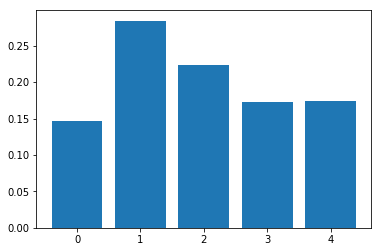

In [14]:
displayClusters(bgmmLabels, bgmmReps,columnLabels)

In [16]:
makeTree(userdf.values,bgmmLabels,'Usage Images/bgmmTree',3,columnLabels)

## Birch

Fit the model

In [17]:
birchLabels, birch = cluster(birch, userdf)

Find mean of each cluster

In [18]:
n_samples,n_features = userdf.values.shape

In [19]:
birchLabelCounts = countLabels(birchLabels)
birchReps = np.zeros((len(birchLabelCounts),n_features))
for key in birchLabelCounts:
    clusterCore = userdf.values[birchLabels == key]
    clusterMean = np.mean(clusterCore, axis=0)
    birchReps[key,:] = clusterMean

Display the results

,desktop,spring,hour,sessionTime,NumSessions,Proportions
0,0.96,0.85,0.64,0.23,0.09,0.55
1,0.26,0.16,0.57,0.20,0.11,0.06
2,0.26,0.93,0.57,0.28,0.14,0.10
3,0.99,0.04,0.64,0.13,0.03,0.23
4,0.84,0.72,0.62,0.36,0.70,0.07


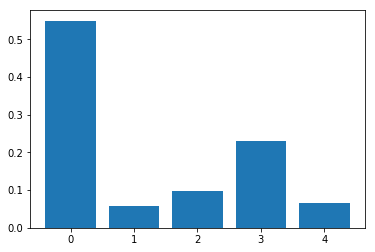

In [20]:
displayClusters(birchLabels, birchReps,columnLabels)

In [22]:
makeTree(userdf.values,birchLabels,'Images/birchTree',2,columnLabels)

## K-means

Fit the model and save the representatives and labels

In [23]:
kmeansLabels, kmeans = cluster(kmeans, userdf)

Get cluster centers

In [24]:
kmeansReps = kmeans.cluster_centers_

Display the results

,desktop,spring,hour,sessionTime,NumSessions,Proportions
0,0.99,0.11,0.64,0.13,0.04,0.28
1,0.99,0.96,0.65,0.14,0.04,0.35
2,0.27,0.93,0.57,0.29,0.15,0.10
3,0.90,0.75,0.62,0.45,0.37,0.20
4,0.30,0.19,0.58,0.21,0.13,0.07


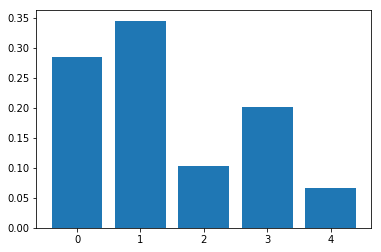

In [25]:
displayClusters(kmeansLabels, kmeansReps,columnLabels)

In [27]:
makeTree(userdf.values,kmeansLabels,'Images/kmeansTree',3,columnLabels)

## Agglomerative (Ward)

Define necessary parameters

In [28]:
method = 'ward'
small_data = getSample(userdf, 1000)

Fit the model

In [29]:
wardClusters = linkage(small_data,method=method)

Display the results

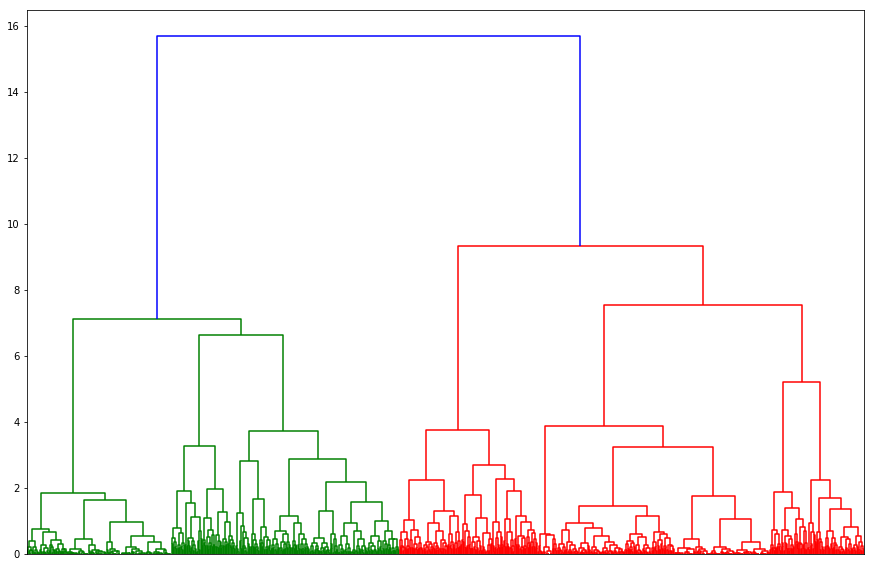

In [30]:
plt.figure(figsize=(15,10))
_ = dendrogram(wardClusters,no_labels=True,p=15,truncate_mode='level')

In [31]:
wardLabels = fcluster(wardClusters, 5, criterion='maxclust')
wardLabels = wardLabels - 1
wardLabelCounts = countLabels(wardLabels)

In [33]:
wardReps = np.zeros((len(wardLabelCounts),n_features))
for key in range(max(wardLabels)):
    clusterCore = small_data[wardLabels == key + 1]
    clusterMean = np.mean(clusterCore, axis=0)
    wardReps[key,:] = clusterMean

,desktop,spring,hour,sessionTime,NumSessions,Proportions
0,0.80,0.38,0.59,0.25,0.14,0.17
1,0.36,0.91,0.60,0.31,0.18,0.27
2,0.99,0.98,0.66,0.13,0.05,0.16
3,0.92,0.83,0.62,0.55,0.44,0.29
4,0.00,0.00,0.00,0.00,0.00,0.11


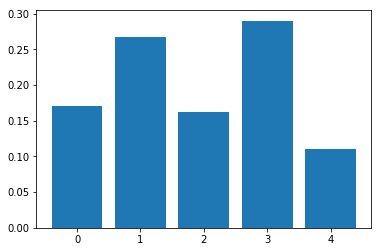

In [34]:
displayClusters(wardLabels,wardReps,columnLabels)

In [35]:
makeTree(small_data,wardLabels,'Images/wardTree',3,columnLabels)